In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint

from math import gcd
import pandas as pd
from fractions import Fraction

from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

print("Imports Successful")

Imports Successful


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Init Circuit

In [3]:
phaseBitsQubits = 3
functionValueQubits = 2

In [4]:
shorCircuit = QuantumCircuit(phaseBitsQubits + functionValueQubits, phaseBitsQubits)

### - apply Hadamard gates

In [5]:
preCircuit = QuantumCircuit(phaseBitsQubits + functionValueQubits, phaseBitsQubits)

for i in range(phaseBitsQubits):
    preCircuit.h(i)

preCircuit.barrier()

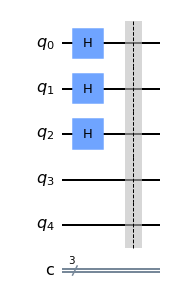

In [6]:
preCircuit.draw(output='mpl')

###  - apply Uf gates

In [16]:
# https://arxiv.org/pdf/1310.6446v2.pdf
# https://quantumcomputing.stackexchange.com/questions/8843/implementing-qft-for-shors-algorithm

In [7]:
unitaryFunctionCircuit = QuantumCircuit(phaseBitsQubits + functionValueQubits, phaseBitsQubits)

unitaryFunctionCircuit.cx(1, 0)
unitaryFunctionCircuit.cx(1, 2)
unitaryFunctionCircuit.toffoli(0, 2, 3)
unitaryFunctionCircuit.cx(1, 0)
unitaryFunctionCircuit.x(0)
unitaryFunctionCircuit.toffoli(0, 3, 4)
unitaryFunctionCircuit.x(0)
unitaryFunctionCircuit.cx(2, 4)
unitaryFunctionCircuit.cx(0, 4)
unitaryFunctionCircuit.cx(1, 2)

unitaryFunctionCircuit.barrier()

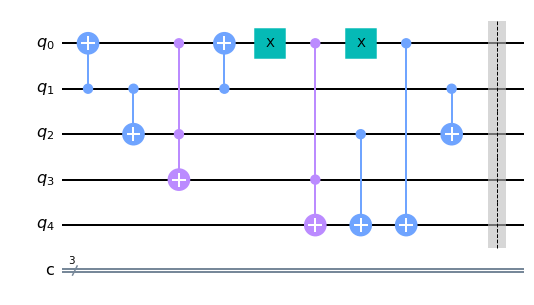

In [8]:
unitaryFunctionCircuit.draw(output='mpl')

### - apply QFT-dagger

In [9]:
from qiskit.circuit.library.standard_gates import SdgGate, TdgGate

csdggate = SdgGate().control(1) # the parameter is the amount of control points you want
ctdggate = TdgGate().control(1)

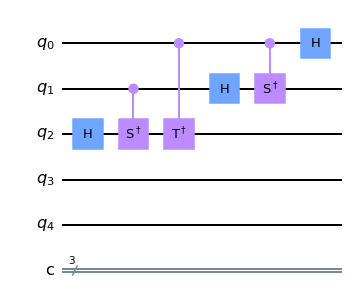

In [10]:
qftDagCircuit = QuantumCircuit(phaseBitsQubits + functionValueQubits, phaseBitsQubits)

qftDagCircuit.h(2)
qftDagCircuit.append(csdggate, [1, 2])
qftDagCircuit.append(ctdggate, [0, 2])
qftDagCircuit.h(1)
qftDagCircuit.append(csdggate, [0, 1])
qftDagCircuit.h(0)

qftDagCircuit.draw(output='mpl')

### - full shor circuit

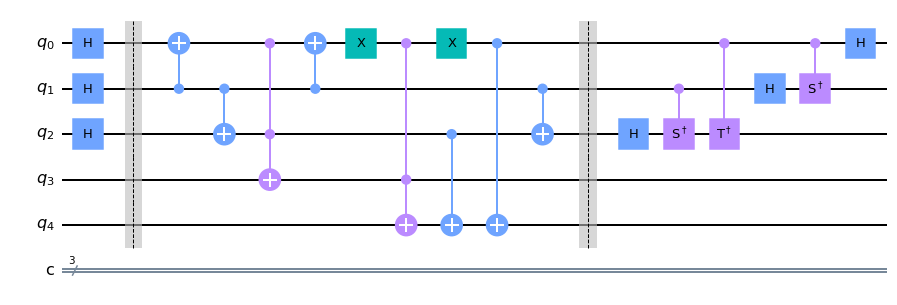

In [17]:
shorCircuit = shorCircuit.compose(preCircuit).compose(unitaryFunctionCircuit).compose(qftDagCircuit)

shorCircuit.draw(output='mpl')

##  Measure and guess factor

In [101]:
def qpe(circuit):
    circuit.measure(range(phaseBitsQubits), range(phaseBitsQubits))
    
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')

    # Setting memory=True below allows us to see a list of each sequential reading
    t_circuit = transpile(circuit, aer_sim)
    qobj = assemble(t_circuit, shots=1)
    result = aer_sim.run(qobj, memory=True).result()

    readings = result.get_memory()
    print("Register Reading: " + readings[0])

    phase = int(readings[0], 2) / (2 ** phaseBitsQubits)
    print("Corresponding Phase: %f" % phase)
    
    return phase

In [136]:
N = 21
a = 4

phase = qpe(shorCircuit) # Phase = s/r
Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r

Register Reading: 101
Corresponding Phase: 0.625000


Fraction(5, 8)

In [164]:
frac = Fraction(phase).limit_denominator(N)
s, r = frac.numerator, frac.denominator
print(r)

8


In [167]:
r = 6
guesses = [gcd(int(a ** (r / 2) - 1), N), gcd(int(a ** (r / 2) + 1), N)]
print(sorted(guesses))

[1, 21]


In [108]:
factor_found = False
attempt = 0

print(f'N: {N}, a: {a}')

while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    
    phase = qpe(shorCircuit) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = sorted([gcd(a ** (r // 2) - 1, N), gcd(a ** (r // 2) + 1, N)])
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True

N: 21, a: 4

Attempt 1:
Register Reading: 010
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 1 and 3
*** Non-trivial factor found: 3 ***


## Second type of unitary function

In [109]:
shorCircuit2 = QuantumCircuit(phaseBitsQubits + functionValueQubits, phaseBitsQubits)

### - different type of unitary function

In [159]:
# https://arxiv.org/pdf/2103.13855.pdf

In [110]:
unitaryFunctionCircuit2 = QuantumCircuit(phaseBitsQubits + functionValueQubits, phaseBitsQubits)

unitaryFunctionCircuit2.cx(2, 4)
unitaryFunctionCircuit2.barrier()

unitaryFunctionCircuit2.cx(1, 4)
unitaryFunctionCircuit2.cx(4, 3)
unitaryFunctionCircuit2.toffoli(1, 3, 4)
unitaryFunctionCircuit2.cx(4, 3)
unitaryFunctionCircuit2.barrier()

unitaryFunctionCircuit2.x(4)
unitaryFunctionCircuit2.toffoli(0, 4, 3)
unitaryFunctionCircuit2.x(4)
unitaryFunctionCircuit2.cx(4, 3)
unitaryFunctionCircuit2.toffoli(0, 3, 4)
unitaryFunctionCircuit2.cx(4, 3)
unitaryFunctionCircuit2.barrier()

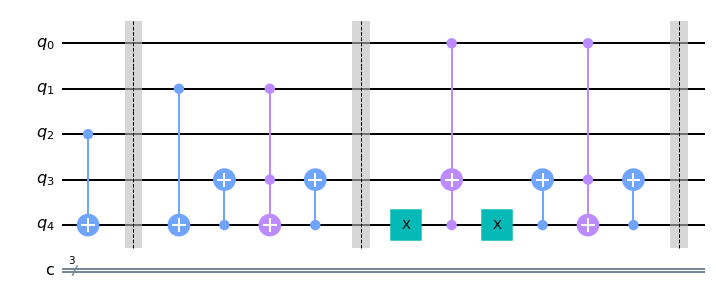

In [111]:
unitaryFunctionCircuit2.draw(output='mpl')

### - full circuit 2

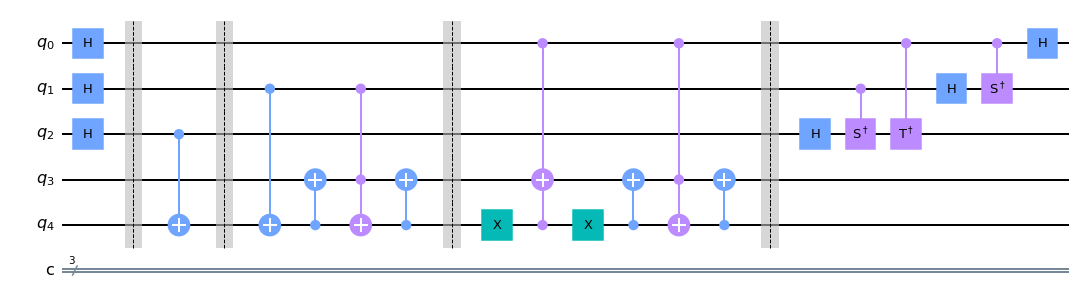

In [112]:
shorCircuit2 = shorCircuit2.compose(preCircuit).compose(unitaryFunctionCircuit2).compose(qftDagCircuit)

shorCircuit2.draw(output='mpl')

In [135]:
factor_found = False
attempt = 0

print(f'N: {N}, a: {a}')

while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    
    phase = qpe(shorCircuit2) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = sorted([gcd(a ** (r // 2) - 1, N), gcd(a ** (r // 2) + 1, N)])
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True

N: 21, a: 4

Attempt 1:
Register Reading: 000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 2:
Register Reading: 110
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 1 and 3
*** Non-trivial factor found: 3 ***


## Full circuit 3 (8 qubits)

In [169]:
phaseBitsQubits3 = 3
functionValueQubits3 = 5

In [170]:
shorCircuit3 = QuantumCircuit(phaseBitsQubits3 + functionValueQubits3, phaseBitsQubits3)

### - apply Hadamard gates

In [171]:
preCircuit3 = QuantumCircuit(phaseBitsQubits3 + functionValueQubits3, phaseBitsQubits3)

for i in range(phaseBitsQubits3):
    preCircuit3.h(i)

preCircuit3.barrier()

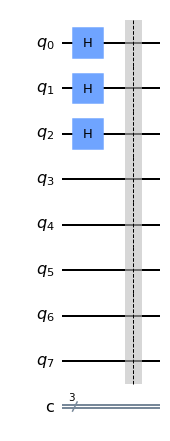

In [172]:
preCircuit3.draw(output='mpl')

###  - apply Uf gates

In [173]:
# https://arxiv.org/pdf/1310.6446v2.pdf

In [174]:
unitaryFunctionCircuit3 = QuantumCircuit(phaseBitsQubits3 + functionValueQubits3, phaseBitsQubits3)

unitaryFunctionCircuit3.cx(1, 5)
unitaryFunctionCircuit3.cx(2, 5)
unitaryFunctionCircuit3.cx(1, 7)
unitaryFunctionCircuit3.cx(0, 7)
unitaryFunctionCircuit3.toffoli(7, 5, 3)
unitaryFunctionCircuit3.cx(0, 7)
unitaryFunctionCircuit3.cx(1, 7)
unitaryFunctionCircuit3.toffoli(0, 3, 7)
unitaryFunctionCircuit3.cx(3, 5)
unitaryFunctionCircuit3.cx(7, 5)
unitaryFunctionCircuit3.cx(0, 5)
unitaryFunctionCircuit3.x(7)
unitaryFunctionCircuit3.cx(2, 7)
unitaryFunctionCircuit3.cx(1, 7)
unitaryFunctionCircuit3.cx(0, 7)

unitaryFunctionCircuit3.barrier()

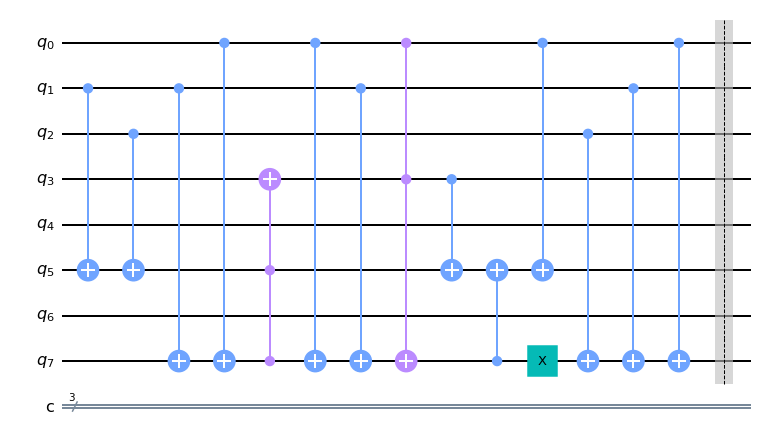

In [175]:
unitaryFunctionCircuit3.draw(output='mpl')

### - apply QFT-dagger

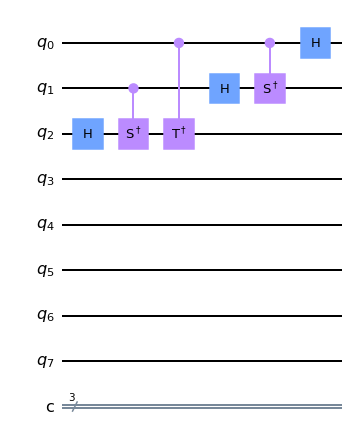

In [176]:
qftDagCircuit3 = QuantumCircuit(phaseBitsQubits3 + functionValueQubits3, phaseBitsQubits3)

qftDagCircuit3.h(2)
qftDagCircuit3.append(csdggate, [1, 2])
qftDagCircuit3.append(ctdggate, [0, 2])
qftDagCircuit3.h(1)
qftDagCircuit3.append(csdggate, [0, 1])
qftDagCircuit3.h(0)

qftDagCircuit3.draw(output='mpl')

### - full circuit

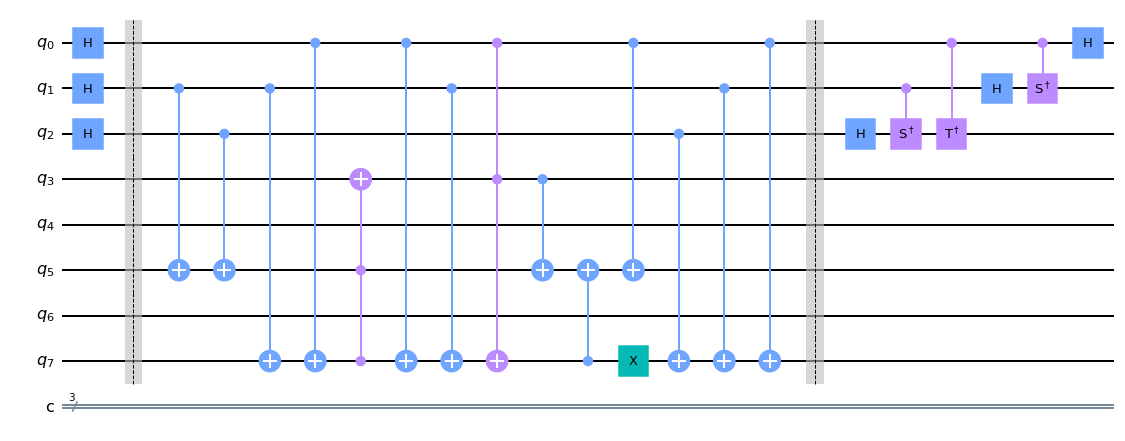

In [177]:
shorCircuit3 = shorCircuit3.compose(preCircuit3).compose(unitaryFunctionCircuit3).compose(qftDagCircuit3)

shorCircuit3.draw(output='mpl')

### - measure test

In [198]:
factor_found = False
attempt = 0

print(f'N: {N}, a: {a}')

while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    
    phase = qpe(shorCircuit3) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = sorted([gcd(a ** (r // 2) - 1, N), gcd(a ** (r // 2) + 1, N)])
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True

N: 21, a: 4

Attempt 1:
Register Reading: 101
Corresponding Phase: 0.625000
Result: r = 8
Guessed Factors: 1 and 3
*** Non-trivial factor found: 3 ***
